# Image and video compression

## JPEG Compression

Every compression algorithm consists of the following blocks:

    Mapper - Quantizer - Symbol encoder

While the decoding process consists in:

    Symbol decoder - Inverse Mapper

The output can be exactly the same image in the input, in which case it is a **loseless compression**.

The JPEG mapper takes an image, divides it into $8 \, pix \times 8 \, pix$ sub-images and then feeds them to a DCT. The output of the DCT is quantized and then the symbol encoder uses Huffman coding. Quantization provides some size reduction but the encoding can further increase the compression.

### Mapper

The front portion of the algorithm begins with the construction of a grid of $8 \, pix \times 8 \, pix$ images (even if the actual dimensions are not multiples of $8$). They are all encoded almost independently. Pure JPEG is color-blind, it does not deal with inter-color information and their correlation. Nonetheless, some assumptions are made and the compression is actually performed in the $YC_bC_y$ (luminance $+\,2\,\times$ chrominance) coding. This is obtained as a linear transformation of the RGB image:

$$
\left[ \begin{array}
    .Y \\ C_b \\ C_y
\end{array} \right] = 
\left[ \begin{array}
    ....&...&... \\
    ...&...&... \\
    ...&...&...
\end{array} \right] \cdot
\left[\begin{array}
    .R \\ G \\ B
\end{array} \right]
$$

The transformation matrix is a constante one and is already established, it is available online.

Further, after the grid is obtained and translated into luminance and chrominance, a Discrete Cosine Transform is applied as a forward transform before the quantization step. The reason for this transformation step is that it may allow to express the same image, without any loss, in a more sparse domain. And therefore, by discarding null values, it would enable a more efficient and yet as faithful transmission.

**Kahunen-Loève transforms** (KLT) does this and ensures that, by discarding 63 of the 64 elements in the $8 \times 8$ block, the first one contains the lowest possible error. This is because it decorrelates the elements of the image in an optimal way. The issue is it is image-dependent, so it turns out not to be efficient.

DCT has a fix, constant transformation matrix, so despite being suboptimal it is efficient because it does not need to be re-computed.

$$
T(u, v) = \sum_{x=0}^{n-1} \sum_{y=0}^{n-1} f(x,y) \cdot r(x,y,u,v)
$$

In the KLT the $r(x,y,u,v)$ kernels are image-dependent. They vary not only with position but also with the values themselves. Because of that, their computation is too expensive and impractical. On the other hand, in the DCT they do not change with the image, but are given by formulae. After the summation over $x,y$, these variables disappear and leave only $u,v$ in the output, whose domains are also $8 \times 8$. The coefficients for the forward and inverse transforms are actually the same and can be calculated as follows:

$$
r(x,y,u,v) = s(x,y,u,v) = \alpha(u) \, \alpha(v) \cdot cos \left[ \frac{\left(2 x + 1 \right) \, u \, \pi }{2n} \right] \cdot cos \left[ \frac{\left(2 y + 1 \right) \, v \, \pi }{2n} \right]
$$
where
$$
\alpha(u) = \alpha(v) = \left\{ \begin{array}
    .\sqrt{\frac{1}{n}}, \, u=0 \\
    \sqrt{\frac{1}{n}}, \, u \neq 0
\end{array} \right.
$$

DCT is chosen over Fourier, Hadamard transform or any other one because in very specific cases (when the image is Markovian) it is exactly equal to the KLT. An image is Markovian when a pixel value depends directly on the value of the pixel next to it. In order for the Fourier transform to be applicable, the image needs to satisfy the periodicity condition; meanwhile, the DCT requires that the image is mirrored at the boundary. This is more reasonable condition. These two arguments make the DCT a good choice over other transforms.

One reason behind the choice of $8 \times 8$ is because it is computationally less expensive to perform the DCT on more blocks than it is to do it over the whole image. Another one is that the Markovian condition is usually better fulfilled/approximated when grabbing smaller blocks rather than bigger regions.

### Quantization



Quantization is the main source of error in the whole process, but without it the compression rate would not be too big. It is applied after the DCT and before the Huffman coding.

There are several quantization methods. Among them are zonal masking, zonal bit allocation and threshold mask. The first one forces which DCT coefficients are kept and which not, the second one assigns the different coefficients different bit resolutions and the latter gates the coefficients, keeping only those whose values surpass some threshold.

The ordering of the transmission of the coefficients is in a zigzag fashion: first $T(0,0)$ is sent, then $T(0,1)$, then $T(1,0)$, then $T(2,0)$, then $T(1,1)$, etc., as Figure 1 shows. This is important because when the algorithm reaches an element whose value is zero, it sends an End Of Block flag that communicates this and the rest of the elements are not transmitted.


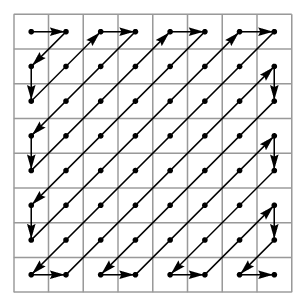

Figure 1. Thresholded coefficient ordering zigzag sequence.

The quantization per se can be uniform, as Figure 2 represents. A benefit of this method is that it makes many values from the domain end up in one value in the codomain. This allows for an efficient encoding later in the Huffman coding block, as the resulting value has now higher probability of appearing. Specifically, the uniform quantization is performed by dividing by a value, rounding down and then scaling by the same value.

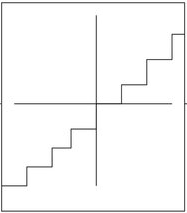

Figure 2. Uniform quantizer.

The standard scaling table (called Z) is actually not uniform but has bigger values, corresponding to coarser quantization, for coefficients corresponding to intermediate frequency kernels and then falls back to small scalars for higher ones. The usual way to specify the quality at which an image should be saved ("low", "mid", "high") corresponds to the  multiplication of the whole table by a number. The bigger the number, the stronger the quantization.

There are other techniques, such as the Max-Lloyd optimal quantizer, that further adapt the quantization to the signal time. The Max-Lloyd example is a non-uniform quantizer that has finer resolution for smaller values and a progressively coarser one for higher values? It defines the quantization steps as a function of the probability distribution of the image. This is usually not solvable in a closed form, and is not as universal as the uniform distribution JPEG uses.

### Huffman coding

Huffman coding provides a **variable length code**, constructed by grouping the two least probable values and adds their probabilities iteratively until there are only two symbols. Then it creates the code backwards: adding a LSB for each bifurcation.

No word (code) is a prefix of any other code, which makes it easy to perform a lookup. This is called **prefix-free**. That is how it knows whether it needs to wait for another symbol or if it already got all the symbols it needed for that particular code.

## Lossless JPEG (JPEG-LS)

It is the lossless version of JPEG. The technical name is **predictive lossless compression**.

As in LPC, the value of the current pixel is predicted based on the values of previous ones, and what is coded into Huffman coding is the error, the difference between the prediction and the actual value. As the error is transmitted, the coding is completely lossless.

The decoder follow the same process. It uses the same prediction strategy, adds the error to the prediction output and so on.

The art in predictive lossless compression resides in choosing the predictor model. The smaller the error consistently, the better, as Huffman coding appreciates having values as frequent as possible. Even if, every now and then, there is a crass mistake, because the error is transmitted it is not a problem.

Preditive, lossy compression is also possible. In this case, the prediction is done on a quantized version of the error, in order to fully emulate the case of the decoder (which will only see the quantized error).

## MPEG

This method enables the compression of video files. It is also based on predictive coding, but with the addition of a temporal sense because of the multiple, sequential frames.

MPEG takes advantage of the local similarities between the adjacent frames. For a region in the current frame, it looks for similar portions in close regions in previous frames. 

## Run-length coding

It is useful for the codification of binary images. It surfaces from aiming to transmit how many subsequent pixels of the same value are next.

Instead of transmitting that many times the same value, it is sent once along with the number of times it need be represented next. This is performed each time there is a change in pixel value, which can be far less times than the total amount of pixels to be transmitted.